# Rudimentary Image Processing
## Images as a function
$$\textrm{Images are simply a function where }I = f(x,y) \textrm{ where I is the intensity, assuming black & white images}$$
* Hence images can be added, multiplied by a scalar, etc.... Can be used for blending images
* Images can be subtracted to find the difference between them
  * Have to be careful while subtracting images as it's uint8_t... So they get floored to 0. Best to convert to float32 before any operation

## Noise in Images
$$\vec{I'}(x,y) = \vec{I}(x,y) + \vec{\eta}(x,y)$$
Noise is just another function that's combined with the image to create the noisy image
* Salt & Pepper noise: Random occurances of black and white pixels
* Impulse noise: Random occurance of white pixels
* Gaussian noise: Variation in intensity drawn from a Guassian normal distribution
  * It's important to ensure that the std. dev of the noise is within reasonable range of the image range...

# Filtering
1. Weighted moving average: Correlation / Convolutions...
    $$\textrm{Uniform Weighted moving average: }G[i,j] = \frac{1}{(2k+1)^2}\sum_{u=-k}^k\sum_{v=-k}^kF[i+u,j+v]$$
    $$\textrm{Non Uniform Weighted moving average: }G[i,j] = \sum_{u=-k}^k\sum_{v=-k}^kH[u,v]F[i+u,j+v]$$
    Here H[u,v] is called either the kernel, mask or the cross correlation filter
    _So what makes a good kernel??? A very succesful major... Geddit?? :P_

2. Gaussian Filter
This allows us to have a guassian distributed filter coefficients to achieve much better smoothening
$$\frac{1}{16}\begin{bmatrix}
1 & 2 & 1 \\
2 & 4 & 2 \\
1 & 2 & 1 \end{bmatrix}$$
where the guassian equation is
$$H(u,v)=\frac{1}{2\pi\sigma^2}e^{-\frac{u^2+v^2}{\sigma^2}}$$
This kinda filtering only makes sense if the noise is independantly distributed and it's mean is centered around 0... For example, guassian filters won't work with salt & pepper noise

3. Median Filter
  * Instead of taking the average, take the median of the values across it's neighbours. 
  * This isn't a linear operation
  * Median also preserves edges

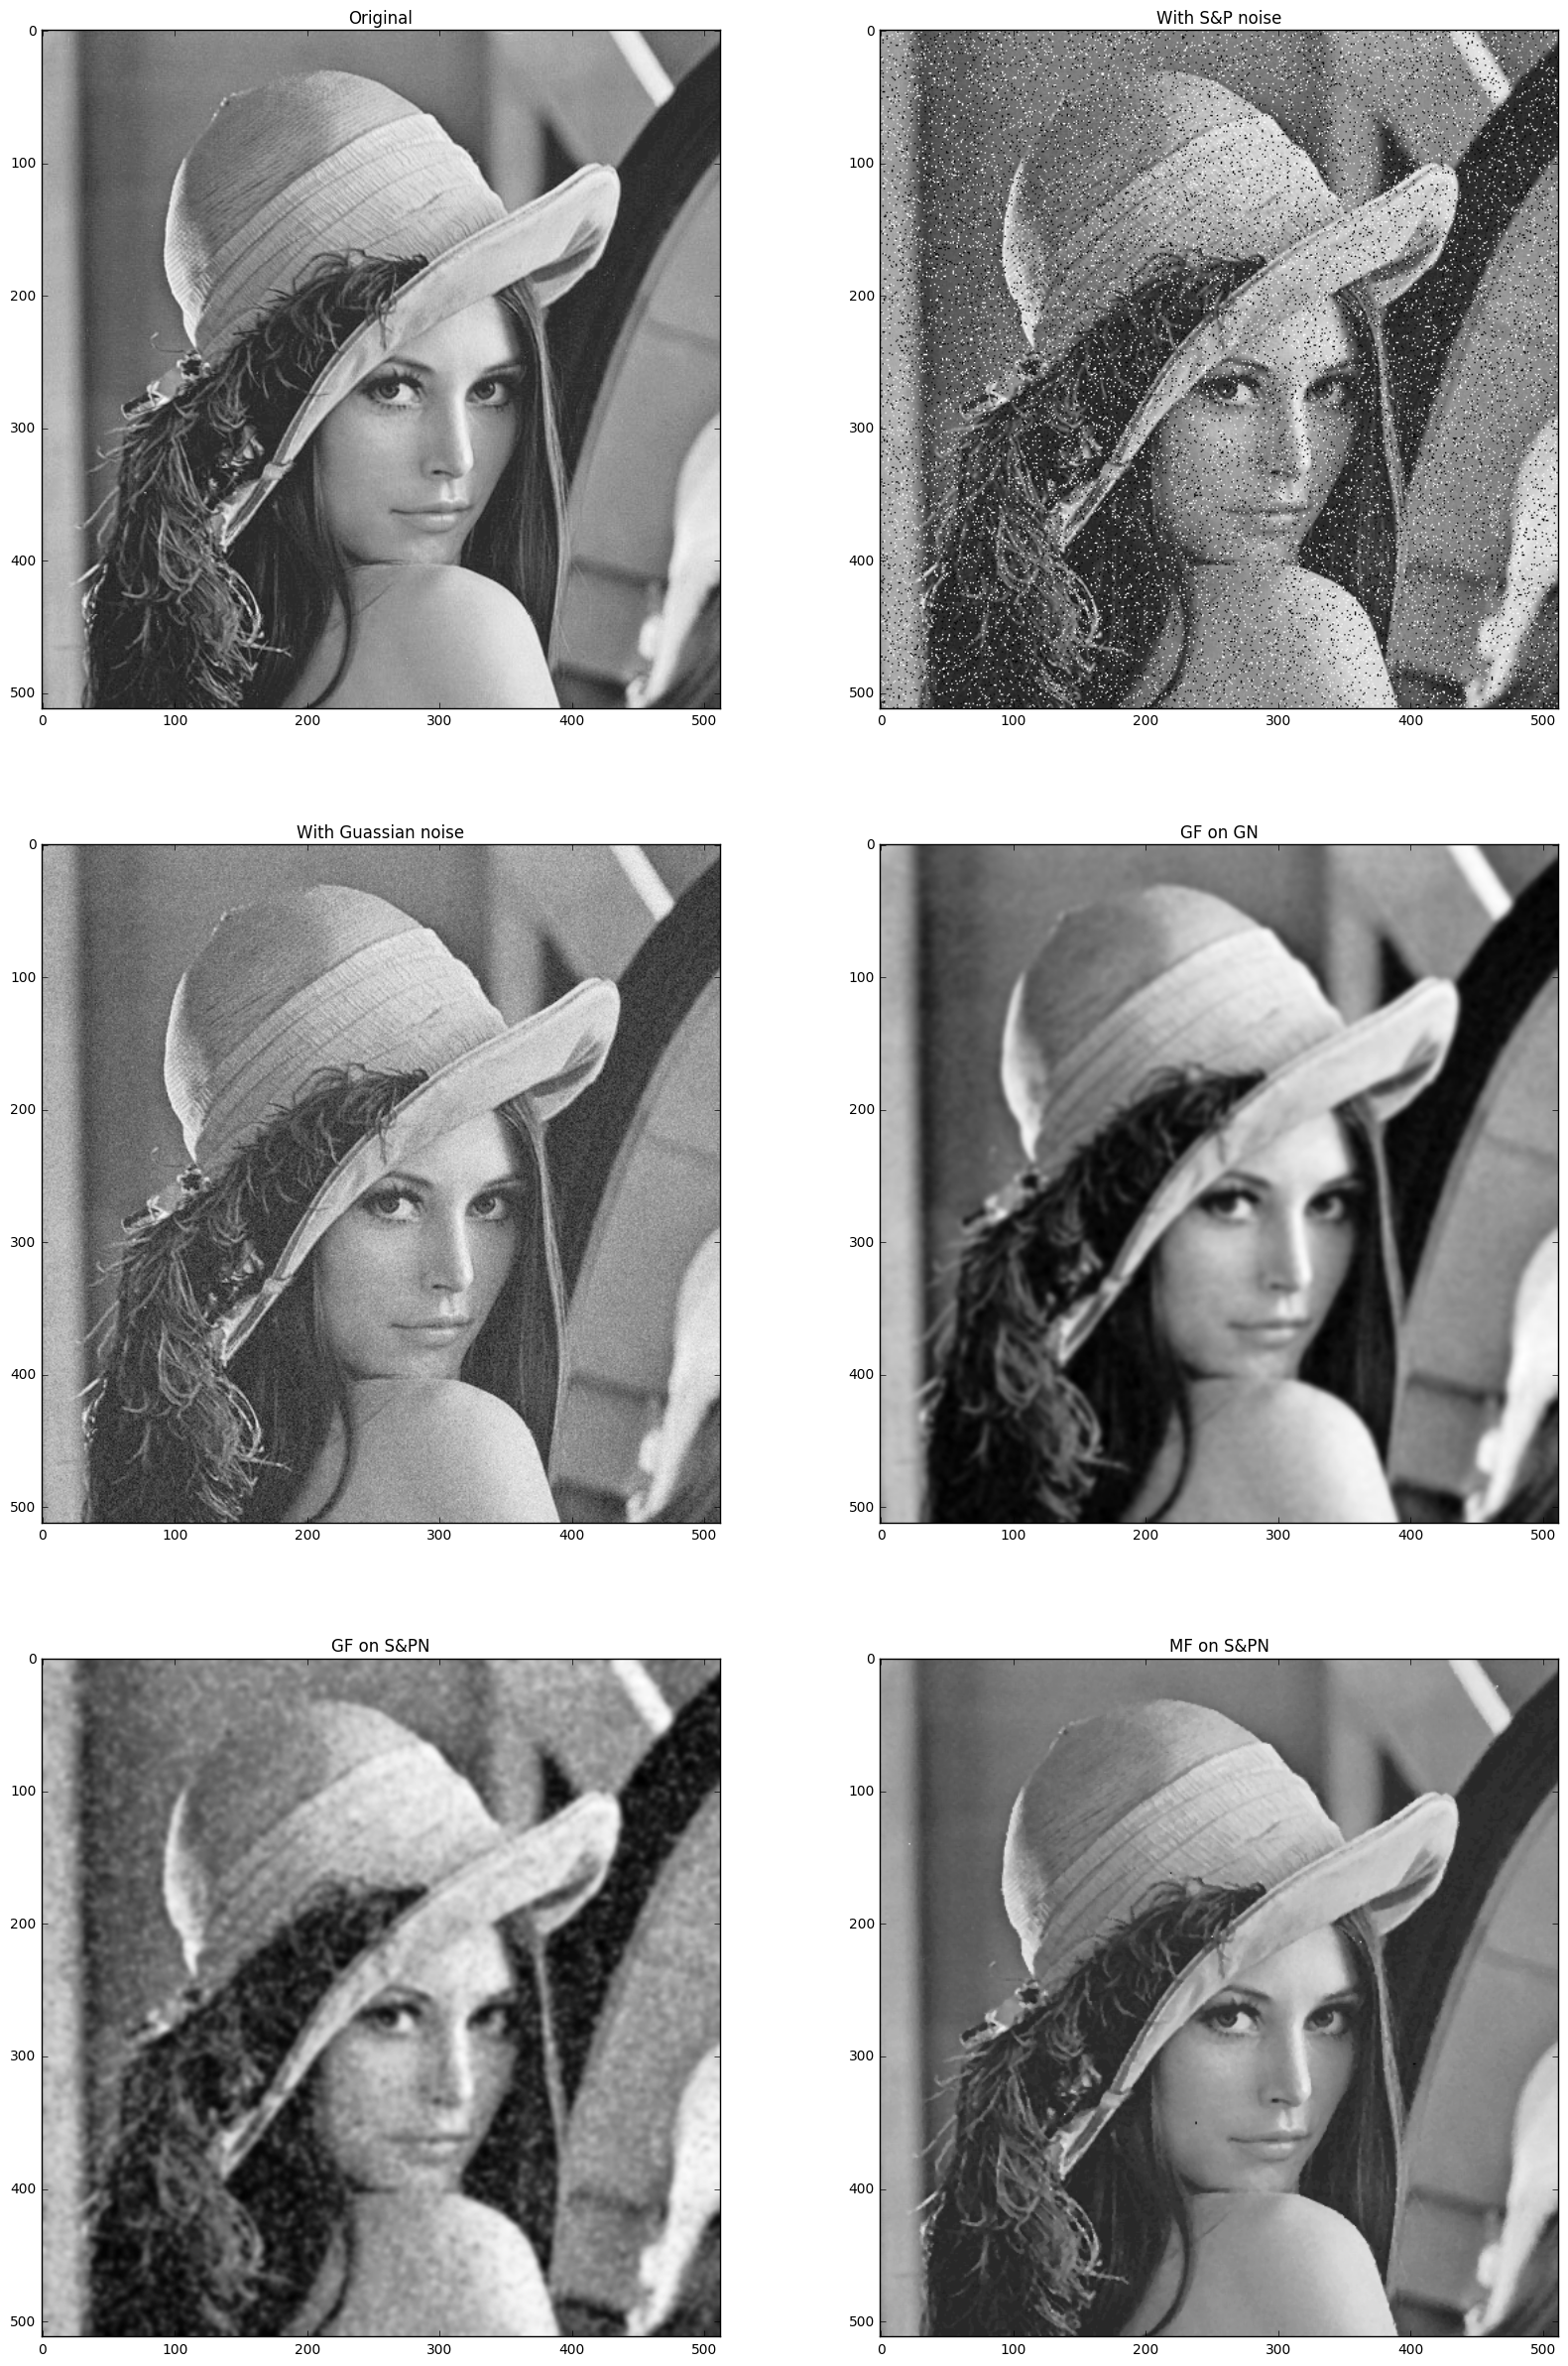

In [88]:
# Implementing a median filter to a salt & pepper noise
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
%matplotlib inline 

# Create a figure
fig = plt.figure(figsize=(20,30))
    
KSIZE = 11

# Get the image
img = cv2.imread("test.png",0)
a=fig.add_subplot(3,2,1)
imgplot = plt.imshow(img, cmap='Greys_r')
a.set_title('Original')

# Add S&P noise to an image
sp_noisy_img = np.copy(img)
sp_noise = np.random.normal(loc=0.5, scale = 0.1, size = img.shape)
for x_idx in np.arange(sp_noise.shape[0]):
    for y_idx in np.arange(sp_noise.shape[1]):
        if sp_noise[x_idx][y_idx] < 0.33:
            sp_noisy_img[x_idx][y_idx] = 0
        elif sp_noise[x_idx][y_idx] > 0.66:
            sp_noisy_img[x_idx][y_idx] = 255
a=fig.add_subplot(3,2,2)            
imgplot = plt.imshow(np.array(sp_noisy_img), cmap='Greys_r')
a.set_title('With S&P noise')

# Add guassian noise to an image
guassian_noisy_img = np.copy(img) + np.random.normal(loc=0, scale=10.0, size=img.shape)
a=fig.add_subplot(3,2,3)  
imgplot = plt.imshow(guassian_noisy_img, cmap='Greys_r')
a.set_title('With Guassian noise')

# Apply a guassian filter to both the noises and measure SNR
fixedimg = cv2.GaussianBlur(guassian_noisy_img,(KSIZE,KSIZE),0)
a=fig.add_subplot(3,2,4)  
imgplot = plt.imshow(np.array(fixedimg), cmap='Greys_r')
a.set_title('GF on GN')

fixedimg = cv2.GaussianBlur(sp_noisy_img,(KSIZE,KSIZE),0)
a=fig.add_subplot(3,2,5)
imgplot = plt.imshow(np.array(fixedimg), cmap='Greys_r')
a.set_title('GF on S&PN')

# Apply a median filter to both the noises and measure SNR
fixedimg = cv2.medianBlur(sp_noisy_img,3)
a=fig.add_subplot(3,2,6)
imgplot = plt.imshow(np.array(fixedimg), cmap='Greys_r')
a.set_title('MF on S&PN')

plt.show()

# Linearity
An opearator H is linear if (f1 and f2 are two functions and c is a constant)
* H(f1 + f2) = H(f1) + H(f2)
* H(c x f1) = c x H(f1)

## Impulse Function
Holy shit... Really holy shit
A single of area 1.0. In a continous world, with lim width tending to 0, it's height is infinity
* In 2-D, an impulse is a single pixel with a value 1

### Impulse Reponse
The response of a blackbox (represented by h(x)) to that impulse t.
* If h(x) is linear, then by looking at h(t), we can describe the entire function h(x), because, every input can be visualized as series of impulses shifted in time, and hence we can add the outputs of each of the impulses to get the output.
* Suppose we send an impulse into a correlation kernel H(u,v), what we'll get is -H(u,v) because of the way the kernel moves over and generates the response. To settle this, convolution and correlation has a different definition.
* Convolving an image with an impulse... well gives the image itself right...

## Correlation vs Convolution
$$\textrm{Cross Correlation: }G[i,j] = \sum_{u=-k}^k\sum_{v=-k}^kH[u,v]F[i+u,j+v]$$
$$\textrm{Convolution: }G[i,j] = \sum_{u=-k}^k\sum_{v=-k}^kH[u,v]F[i-u,j-v]$$
* So if an impulse is sent into a Convolution Kernel, the output is going to remain the same as the kernel itself.
* One thing to note is for a guassian filter (which is symmetric), both convolution and correlation gives the same output.

### Properties of Convolution
* Shift Invariant: Operator behaves the same way irrespective of the pixel's location within the image. 
* Linear opeators
* Commutative: f * g = g * f
* Associative: f * (g * h) = (f * g) * h
* Identity exists: Impulse
* Differention is linear: $$\frac{\partial}{\partial x}(f * g) = \frac{\partial f}{\partial x} * g$$

### Computational Complexity
N x N is the image size and W x W is the size of the kernel
So the number of multiplications is N<sup>2</sup> x W<sup>2</sup>
To get out of this...
$$ \textrm{Let }C=[1,2,1] \textrm{ and }R=\begin{bmatrix}
    1 \\
    2 \\
    1
\end{bmatrix} \textrm{ then H = C * R, i.e. }H = C * R = \begin{bmatrix}
    1 && 2 && 1 \\
    2 && 4 && 2 \\
    1 && 2 && 1
\end{bmatrix}$$
We can use the associative property of convolution to 
$$ img * H = (img * C) * R$$
which brings the complexity down to 2WN<sup>2</sup>

### Padding
* Full - Slightly bigger than the original size
* Same - Retains the original size, we get to specify is the border should be a replicate, or reflect as well.
* Valid - Slightly smaller than the original size

# Filters as templates
We can also use almost similar images as tempaltes. For example if we've a car image and if it's in scale to the original car in the test image, it should be able to find the car... But scaling will be a major headache

## Normalized correlation
To ensure that we are able to compare the results of an image or multiple image's response to multiple filters, we will normalize both the filter as well as the image before the operation.

## 1-D Correlation
When we take a part of the signal and try to correlate it with the image, we get an output signal which will have a peak which corresponds to the location from where we originally took the part of the signal. Like shown below
![1D Correlation](img/1DCorr.png)

('Original offset: ', 104, 330)
('Found offset: ', (104, 330))


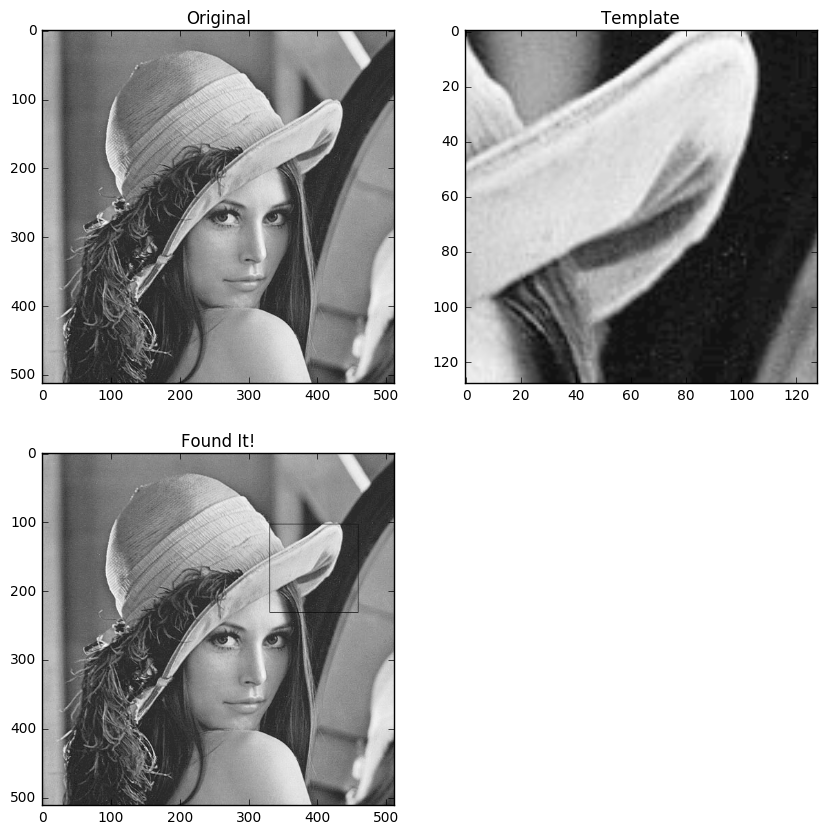

In [166]:
import cv2
import tensorflow as tf
import numpy as np

TSIZE = 128

# Create a figure
fig = plt.figure(figsize=(10,10))

# Get the image
img = cv2.imread("test.png",0)
a=fig.add_subplot(2,2,1)
imgplot = plt.imshow(img, cmap='Greys_r')
a.set_title('Original')

# Create a template randomly
tx_idx = np.random.randint(img.shape[0]-TSIZE)
ty_idx = np.random.randint(img.shape[0]-TSIZE)
temp = np.array(img[tx_idx:tx_idx+TSIZE,ty_idx:ty_idx+TSIZE])
a=fig.add_subplot(2,2,2)
imgplot = plt.imshow(temp, cmap='Greys_r')
a.set_title('Template')

# Let's do template matching
match = cv2.matchTemplate(img, temp, method=cv2.TM_CCORR_NORMED)

# Let's check
x,y = np.unravel_index(match.argmax(), match.shape)
out = cv2.rectangle(img, (ty_idx,tx_idx), (ty_idx+TSIZE, tx_idx+TSIZE), color=10) # rectangle function takes x & y in rev...
a=fig.add_subplot(2,2,3)
imgplot = plt.imshow(out, cmap='Greys_r')
a.set_title('Found It!')

print ('Original offset: ', tx_idx, ty_idx)
print ('Found offset: ', np.unravel_index(match.argmax(), match.shape))
plt.show()


# Edge Detection
Most images with just edges (pencil sketches, cartoons) still convey the complete context of the image. Hence edges are extremely important to the perception of the image.

## Different Types of edges
![Types of Edges](img/Edges.png)

## Finding Edges
Edges can be found by taking a differential along any of the axis... This can be moddelled to a filter operation
$$\textrm{Gradient of an image: }\Delta f = [\frac{\partial f}{\partial x},\frac{\partial f}{\partial y}]$$
$$\textrm{Direction of the gradient: }\theta = \tan^{-1}(\frac{\partial f}{\partial x},\frac{\partial f}{\partial y})$$
$$\textrm{Amount of change: }\| \mathbf{\Delta f} \| = \sqrt{\Big(\frac{\partial f}{\partial x}\Big)^2 + \Big(\frac{\partial f}{\partial y}\Big)^2}$$

### Predefined Operator
[Sobel](https://en.wikipedia.org/wiki/Sobel_operator) is one of the most famous operators for modelling partial derivatives.
[Laplacian](https://en.wikipedia.org/wiki/Laplace_operator) opperator is equally good and will get us both the dimension derivative in a single operation...

### Noisy Images
* Noisy images makes it a mess to try and get the edge, so that's where filtering becomes extremely important
* Note... that using associative property, we can apply the filter directly to the edge image, rather than the original image... or even better is to save the derivative of the filter as the filter and just apply it. That would work too. So filtering and edge detection in a single convolution...

### Canny Edge Detector
Canny edge detector is a detector that does the following basic functions needed. A typical edge detector needs to do the following
1. Smoothing derivative (derivative of a smoothing filter) applied to the image to get the edge pixels
  * Canny takes a guassian derivative
2. Threshold to find regions of "significant" gradient
3. "Thin" the edges so it's localized
  * Non maximum suppression
4. Connect / link the edges to get a contour
  * Uses two thresholds, high to find the definite edge and start the contour from there, and then a low threshold to continue the contour...

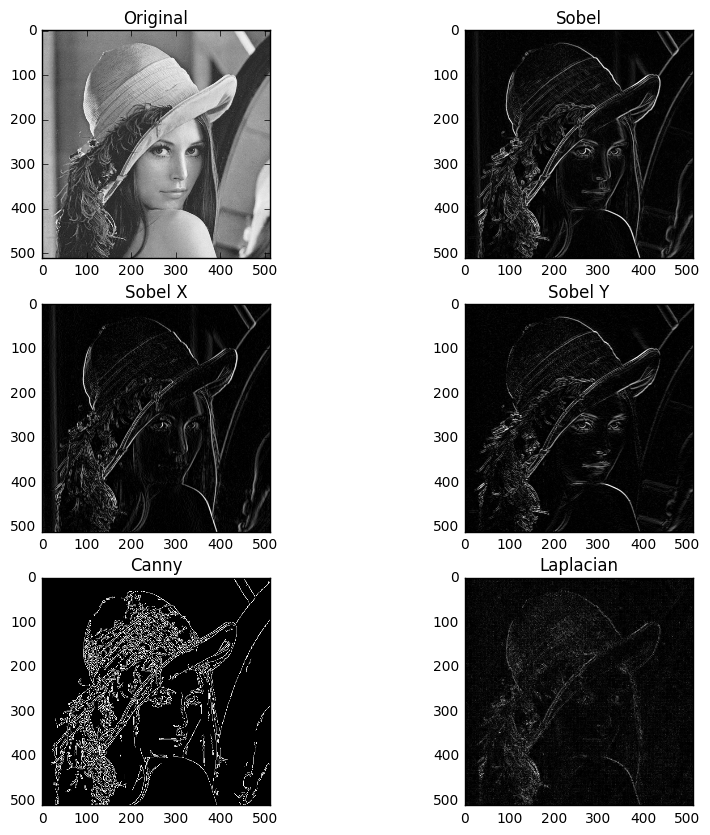

In [189]:
import cv2
import tensorflow as tf
import numpy as np

TSIZE = 128

# Create a figure
fig = plt.figure(figsize=(10,10))

# Get the image
img = cv2.imread("test.png",0)
a=fig.add_subplot(3,2,1)
imgplot = plt.imshow(img, cmap='Greys_r')
a.set_title('Original')

# Apply the sobel operator
sobelx = np.absolute(cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5))
a=fig.add_subplot(3,2,3)
imgplot = plt.imshow(sobelx, cmap='Greys_r')
a.set_title('Sobel X')

sobely = np.absolute(cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5))
a=fig.add_subplot(3,2,4)
imgplot = plt.imshow(sobely, cmap='Greys_r')
a.set_title('Sobel Y')

a=fig.add_subplot(3,2,2)
imgplot = plt.imshow(sobelx + sobely, cmap='Greys_r')
a.set_title('Sobel')

# Apply the canny operator
canny = cv2.Canny(img, 50, 150)
a=fig.add_subplot(3,2,5)
imgplot = plt.imshow(canny, cmap='Greys_r')
a.set_title('Canny')

# Apply the laplacian operator
laplacian = np.absolute(cv2.Laplacian(img,cv2.CV_64F))
a=fig.add_subplot(3,2,6)
imgplot = plt.imshow(laplacian, cmap='Greys_r')
a.set_title('Laplacian')

plt.show()

In [ ]:
# Implement the above with 